In [5]:
import numpy as np
import tensorflow.compat.v1 as tf
from tensorflow.compat.v1 import keras
from tensorflow.compat.v1.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
tfd=tfp.distributions
from tensorflow.keras.datasets import mnist
from sklearn.utils import shuffle
tf.compat.v1.disable_eager_execution()

## VAE TF

### Dense layer from scratch

In [2]:
class Denseab(object):
    def __init__(self,m,n,f=tf.nn.relu):
        self.W=tf.Variable(tf.random_normal((m,n))* 2 / np.sqrt(m))
        self.b=tf.Variable(tf.zeros(n),dtype=tf.float32)
        self.f=f
    def forward(self,X):
        return(self.f(tf.matmul(X,self.W)+self.b))

In [39]:
#x=layers.Flatten()(X)
#ab=Denseab(x.shape[1],200)
#Denseab(ab.forward(x).numpy().shape[1],200).forward(ab.forward(x).numpy())
#x=Denseab(x.forward(x).shape[1],200)

In [40]:
def abenc(data,tam):
    x=layers.Flatten()(data)
    x=Denseab(x.shape[1],200).forward(x)
    x=Denseab(x.shape[1],200).forward(x)
    mu=Denseab(x.shape[1],tam).forward(x)
    sig=Denseab(x.shape[1],tam,keras.activations.softplus).forward(x)
    return(mu,sig)

#abenc(X[0:1],2)
#tfd.MultivariateNormalDiag(a,b).sample()

In [41]:
#tfd.MultivariateNormalDiag(abenc(X,2)[0],abenc(X,2)[1]).sample(5).shape

**Nota: Existen diferencias con los resultados que se generan con layers de keras que con los de tflow por eso se usa tf.layers**

In [20]:
def mienc(data,tam):
    x=layers.Flatten()(data)
    x=layers.Dense(200,activation="relu")(x)
    x=layers.Dense(200,activation="relu")(x)
    mu=layers.Dense(tam)(x)
    sig=layers.Dense(tam,activation=keras.activations.softplus)(x)
    return (mu,sig)
    #return(mu+sig*tfd.MultivariateNormalDiag(tf.zeros(tam),tf.ones(tam)).sample())

In [3]:
#X,_=
X,lab=np.concatenate([mnist.load_data()[0][0],mnist.load_data()[1][0]]),np.concatenate([mnist.load_data()[0][1],mnist.load_data()[1][1]])
X=X.astype("float32")/255.0

In [22]:
#mienc(np.expand_dims(X[0],axis=0),2).numpy()
#tf.shape(layers.Flatten()(X))


In [23]:
def midec(dat,tam):
    x=tf.layers.dense(dat,200,tf.nn.relu)#layers.Dense(200,activation="relu")(dat)
    x=tf.layers.dense(x,200,tf.nn.relu)#layers.Dense(200,activation="relu")(x)
    x=tf.layers.dense(x,np.prod(tam))#layers.Dense(np.prod(tam))(x)
    x=tf.reshape(x,[-1]+tam)#layers.Reshape([-1]+tam)(x)
    #se usa una bernoulli para utilizar la métrica de cross_entropy
    return(tfd.Independent(tfd.Bernoulli(x),2))

In [25]:
#midec(mienc(np.expand_dims(X,axis=0),2),[28,28])

In [26]:
mienc = tf.make_template('encoder', mienc)
midec = tf.make_template('decoder', midec)
abenc = tf.make_template('abencoder', abenc)

In [27]:
def plot_codes(ax, codes, labels):
  ax.scatter(codes[:, 0], codes[:, 1], s=2, c=labels, alpha=0.1)
  ax.set_aspect('equal')
  ax.set_xlim(codes.min() - .1, codes.max() + .1)
  ax.set_ylim(codes.min() - .1, codes.max() + .1)
  ax.tick_params(
      axis='both', which='both', left='off', bottom='off',
      labelleft='off', labelbottom='off')


def plot_samples(ax, samples):
  for index, sample in enumerate(samples):
    ax[index].imshow(sample, cmap='gray')
    ax[index].axis('off')

In [28]:
"""fig, ax = plt.subplots(nrows=20, ncols=11, figsize=(10, 20))
with tf.train.MonitoredSession() as sess:
  for epoch in range(20):
    feed = {data: X[:100]}
    test_elbo, test_codes, test_samples = sess.run([elbo, code, samples], feed)
    print('Epoch', epoch, 'elbo', test_elbo)
    ax[epoch, 0].set_ylabel('Epoch {}'.format(epoch))
    plot_codes(ax[epoch, 0], test_codes, lab[:100])
    plot_samples(ax[epoch, 1:], test_samples.reshape(10,28,28))
    for _ in range(600):
      feed = {data: X[:100]}
      sess.run(optimize, feed)
"""      

"fig, ax = plt.subplots(nrows=20, ncols=11, figsize=(10, 20))\nwith tf.train.MonitoredSession() as sess:\n  for epoch in range(20):\n    feed = {data: X[:100]}\n    test_elbo, test_codes, test_samples = sess.run([elbo, code, samples], feed)\n    print('Epoch', epoch, 'elbo', test_elbo)\n    ax[epoch, 0].set_ylabel('Epoch {}'.format(epoch))\n    plot_codes(ax[epoch, 0], test_codes, lab[:100])\n    plot_samples(ax[epoch, 1:], test_samples.reshape(10,28,28))\n    for _ in range(600):\n      feed = {data: X[:100]}\n      sess.run(optimize, feed)\n"

In [29]:
tf.compat.v1.disable_eager_execution() 
data=tf.placeholder(tf.float32,[None,28,28])
cod=abenc(data,2)
post=tfd.MultivariateNormalDiag(cod[0],cod[1])
mues=post.sample()
likev=midec(mues,[28,28]).log_prob(data)
kl=tfd.kl_divergence(post,tfd.MultivariateNormalDiag(tf.zeros(2),tf.ones(2)))
elbo=tf.reduce_mean(likev-kl)
opt=tf.train.AdamOptimizer(.001).minimize(-elbo)
samp=midec(tfd.MultivariateNormalDiag(tf.zeros(2),tf.ones(2)).sample(10),[28,28]).mean()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [30]:
cod

(<tf.Tensor 'abencoder/Relu_2:0' shape=(None, 2) dtype=float32>,
 <tf.Tensor 'abencoder/Softplus:0' shape=(None, 2) dtype=float32>)

In [20]:
cod

(<tf.Tensor 'encoder/dense_2/BiasAdd:0' shape=(None, 2) dtype=float32>,
 <tf.Tensor 'encoder/dense_3/Softplus:0' shape=(None, 2) dtype=float32>)

In [37]:
init=tf.global_variables_initializer()
#fig, ax = plt.subplots(nrows=20, ncols=11, figsize=(10, 20))
with tf.train.MonitoredTrainingSession() as sess:
    loss_vae=[]
    sess.run(init)
    #misimag=[]
    for epoch in range(100):
        telbo,tpost,tsamp=sess.run([elbo,mues,samp],{data:X[60000:]})
        loss_vae.append(telbo)
        #plot_samples(ax,tsamp)
        #tpost=sess.run(mues,{data:X[60000:60100]})
        print("Epoch",epoch,"elbo",telbo)
        for _ in range(10):
            sess.run(opt,{data:X[:4000]})
    #print(tsamp)        

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch 0 elbo -545.72614
Epoch 1 elbo -401.87354
Epoch 2 elbo -269.80634
Epoch 3 elbo -233.10643
Epoch 4 elbo -219.6563
Epoch 5 elbo -211.84152
Epoch 6 elbo -206.6144
Epoch 7 elbo -203.91612
Epoch 8 elbo -203.06177
Epoch 9 elbo -202.61446
Epoch 10 elbo -202.5052
Epoch 11 elbo -202.27797
Epoch 12 elbo -202.11905
Epoch 13 elbo -202.03998
Epoch 14 elbo -201.9162
Epoch 15 elbo -201.76805
Epoch 16 elbo -201.58507
Epoch 17 elbo -201.2603
Epoch 18 elbo -201.02977
Epoch 19 elbo -200.64824
Epoch 20 elbo -200.2222
Epoch 21 elbo -199.57574
Epoch 22 elbo -199.1866
Epoch 23 elbo -198.81995
Epoch 24 elbo -198.33688
Epoch 25 elbo -197.99338
Epoch 26 elbo -197.9466
Epoch 27 elbo -197.7587
Epoch 28 elbo -197.478
Epoch 29 elbo -197.28467
Epoch 30 elbo -197.26375
Epoch 31 elbo -197.11197
Epoch 32 elbo -196.9504
Epoch 33 elbo -196.90887
Epoch 34 elbo -196.73492
Epoch 35 elbo -196.54828
Ep

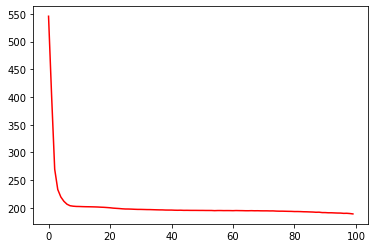

In [38]:
plt.plot(range(len(loss_vae)),np.abs(loss_vae),color="r")

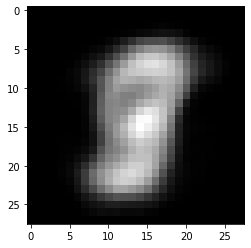

In [36]:
#tfd.Bernoulli(np.array([.2,.3])
plt.imshow(tsamp[0].reshape(28,28),cmap="gray")
#tsamp

## Ejemplo original TF

In [3]:
def make_encoder(data, code_size):
  x = tf.layers.flatten(data)
  x = tf.layers.dense(x, 200, tf.nn.relu)
  x = tf.layers.dense(x, 200, tf.nn.relu)
  loc = tf.layers.dense(x, code_size)
  scale = tf.layers.dense(x, code_size, tf.nn.softplus)
  return tfd.MultivariateNormalDiag(loc, scale)

In [4]:
def make_prior(code_size):
    
    loc = tf.zeros(code_size)
    scale = tf.ones(code_size)
    return tfd.MultivariateNormalDiag(loc, scale)

In [5]:
def make_decoder(code, data_shape):
  x = code
  x = tf.layers.dense(x, 200, tf.nn.relu)
  x = tf.layers.dense(x, 200, tf.nn.relu)
  logit = tf.layers.dense(x, np.prod(data_shape))
  logit=tf.reshape(logit, [-1] + data_shape)
  return tfd.Independent(tfd.Bernoulli(logit), 2)

In [6]:
make_encoder = tf.make_template('encoder', make_encoder)
make_decoder = tf.make_template('decoder', make_decoder)

In [7]:
def plot_codes(ax, codes, labels):
  ax.scatter(codes[:, 0], codes[:, 1], s=2, c=labels, alpha=0.1)
  ax.set_aspect('equal')
  ax.set_xlim(codes.min() - .1, codes.max() + .1)
  ax.set_ylim(codes.min() - .1, codes.max() + .1)
  ax.tick_params(
      axis='both', which='both', left='off', bottom='off',
      labelleft='off', labelbottom='off')


def plot_samples(ax, samples):
  for index, sample in enumerate(samples):
    ax[index].imshow(sample, cmap='gray')
    ax[index].axis('off')

In [8]:
tf.compat.v1.disable_eager_execution() 
data = tf.placeholder(tf.float32, [None, 28, 28])

prior = make_prior(code_size=2)
posterior = make_encoder(data, code_size=2)
code = posterior.sample()

likelihood = make_decoder(code, [28, 28]).log_prob(data)
divergence = tfd.kl_divergence(posterior, prior)
elbo = tf.reduce_mean(likelihood - divergence)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
Use keras.layers.Flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [9]:
optimize = tf.train.AdamOptimizer(0.001).minimize(-elbo)
samples = make_decoder(prior.sample(10), [28, 28]).mean()

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch 0 elbo -543.6382
Epoch 1 elbo -124.29238
Epoch 2 elbo -104.17013
Epoch 3 elbo -93.07702
Epoch 4 elbo -85.071266
Epoch 5 elbo -79.822586
Epoch 6 elbo -77.1055
Epoch 7 elbo -73.5312
Epoch 8 elbo -72.26782
Epoch 9 elbo -69.73136
Epoch 10 elbo -68.45164
Epoch 11 elbo -67.18605
Epoch 12 elbo -65.945366
Epoch 13 elbo -65.11125
Epoch 14 elbo -63.974957
Epoch 15 elbo -63.597424
Epoch 16 elbo -62.97504
Epoch 17 elbo -62.33611
Epoch 18 elbo -61.89729
Epoch 19 elbo -61.49888


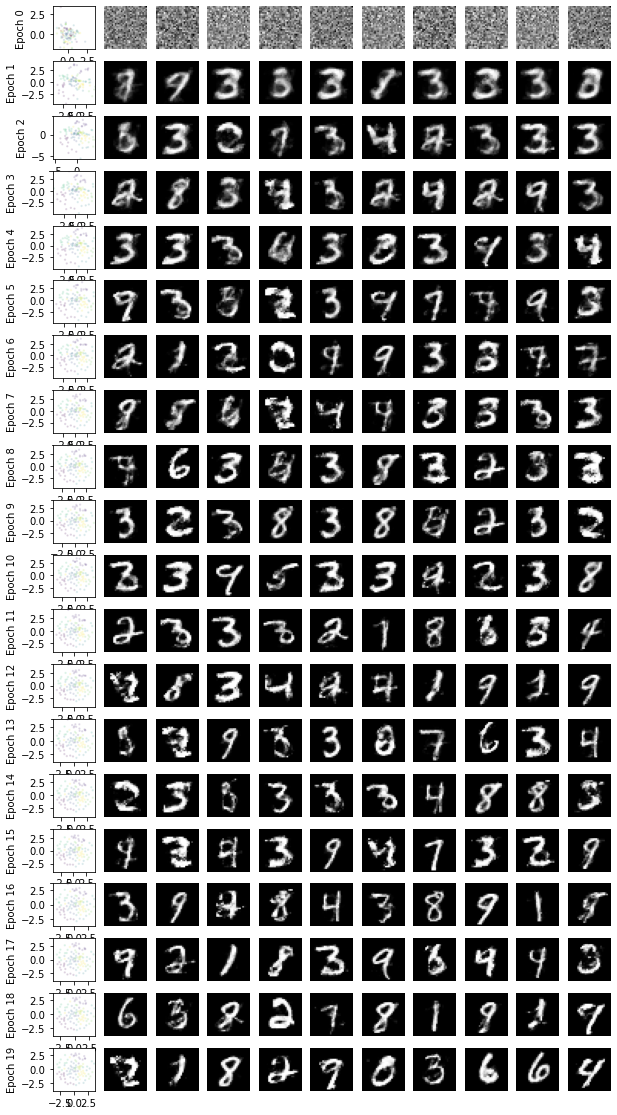

In [10]:
fig, ax = plt.subplots(nrows=20, ncols=11, figsize=(10, 20))
with tf.train.MonitoredSession() as sess:
  for epoch in range(20):
    feed = {data: X[:100]}
    test_elbo, test_codes, test_samples = sess.run([elbo, code, samples], feed)
    print('Epoch', epoch, 'elbo', test_elbo)
    ax[epoch, 0].set_ylabel('Epoch {}'.format(epoch))
    plot_codes(ax[epoch, 0], test_codes, lab[:100])
    plot_samples(ax[epoch, 1:], test_samples)
    for _ in range(600):
      feed = {data: X[:100]}
      sess.run(optimize, feed)

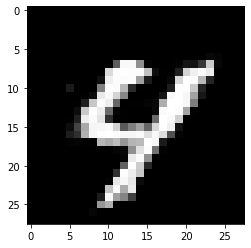

In [14]:
plt.imshow(test_samples[9],cmap="gray")

In [12]:
[-1] + [X[0].shape]

[-1, (28, 28)]

In [50]:
tf.Session().run(np.array([1,1,1])+np.array([1,1,1])*tfd.Normal(np.zeros(3),np.ones(3)).sample())

array([2.56106137, 2.8947331 , 0.22044573])

## VAE Class

In [7]:
from __future__ import print_function, division
from builtins import range, input
class Vae:
    def __init__(self,D,hidden_size):
        #D es la dimensión del input
        #hidden_size es una lista de tamaño número de hidden layers donde 
        # la i-ésima entrada es el numero de unidades de la capa i
        
        # represents a batch of training data
        self.X=tf.placeholder(tf.float32,shape=(None,D))
        
        #encoder
        #listado de layers
        self.enc_lay=[]
        m=D
        #construimos la red neuronal hasta la penúltima capa
        for n in hidden_size[:-1]:
            h=Denseab(m,n)
            self.enc_lay.append(h)
            m=n
        
        #última capa layer
        O=hidden_size[-1]
        print("ojo-----------------fin:",O)
        #en esta última capa vamos a poner tanto las salidas mu  y sigma entonces el tamaña
        #de layer o dimensión sera 2*O
        h=Denseab(m,2*O,f=lambda x: x)
        self.enc_lay.append(h)
        
        #Armamos los calculos de la red usando softplus para la parte de sig o varianza
        inp=self.X
        #hacemos las multiplicaciones de pesos y outputs
        for lay in self.enc_lay:
            out=lay.forward(inp)
            inp=out
        #definimos los atributos mu y sigma tomándolos del último output de las capas y en el caso
        # de sigmas aplicamos softplus para hacer lasa salidas positivas y hacer el truco d reparametrización.
        self.mean=out[:,:O]#las primeras O columnas son mu
        self.sig=tf.nn.softplus(out[:,O:])+1e-6#las segundas O columnas son sig
        print("ojo----------------sig:",self.sig.shape,out.shape)    
        
        #declaramos una distribución normal MULTIVARIADA con media mu y desviación sig
        self.Z_dist=tfd.Normal(self.mean,self.sig)
        e=tfd.Normal(np.zeros(O,dtype=np.float32),np.ones(O,dtype=np.float32)).sample(tf.shape(self.mean)[0])
        #get sample of Z truco de a reparametrización
        self.Z=self.mean+self.sig*e
        
        #decoder
        #Notar que es hacer el mismo proceso de encoder pero hacia atrás
        self.dec=[]
        md=O
        for nd in reversed(hidden_size):
            hd=Denseab(md,nd)
            self.dec.append(hd)
            md=nd
        
        I=D#list(reversed(hidden_size))[-1]
        #para la salida del decoder vamos a aplicar la función sigmoide 
        hd=Denseab(md,I,f=lambda x:x)
        self.dec.append(hd)
        
        print("ojo--------------------------lista:",self.dec,list(reversed(hidden_size)))
        
        #vamos a hacer la nuerona de salida con logits  la distrib binomial
        inpd=self.Z
        for laydec in self.dec:
            outd=laydec.forward(inpd)
            inpd=outd
        #la binomial
        posterior_predictive_logits=inpd#se usa después
        #el output
        self.X_hat_d=tfd.Bernoulli(logits=inpd)
        
        #tomamos una muestra de xhat...
        self.posterior_predictive=self.X_hat_d.sample()
        #sacamos su proba con sigmoid ya que la proba de la bernoulli con logits es sigmoid
        self.posterior_predictive_proba=tf.nn.sigmoid(inpd)
        
        #construyendo e prior...
        self.Z_std=tfd.Normal(np.zeros(O,dtype=np.float32),np.ones(O,dtype=np.float32)).sample(1)
        inpds=self.Z_std
        for laydec in self.dec:
            outds=laydec.forward(inpds)
            inpds=outds
        #la binomial
        prior_predictive_dist=tfd.Bernoulli(logits=inpds)#se usa después
        
        #el output
        #-----------------------------------------------------------------------------------------#
        #--------------¿Qué ch.. hacemos aquí-------------------------------------------------------
        #a partir de 1input muestra  de la distribución Z_std~N(0,1) generamos
        #outputs binarios 
        self.prior_predictive=prior_predictive_dist.sample()
        #sacamos su proba con sigmoid ya que la proba de la bernoulli con logits es sigmoid
        #generamos los outputs aplicando una función sigmoide a diferencia de la distrib bernoulli estas son
        #las probas --sigmoid(WH+b)   
        self.prior_predictive_probs=tf.sigmoid(inpds)
        
        #podemos usar ambas 
        #-----------------------------------------------------------------------------------------
        #-----------------------------------------------------------------------------------------
        
        #-----------------------------------------------------------------------------------------#
        #--------------¿Qué ch.. hacemos aquí-------------------------------------------------------
        #estamos generando los outputs binarios sacanado una muestra de la distribución bernoulli
        #con parámetro p=inpds que es el output de la red WH+b        
        #tomamos una muestra de xhat...
        self.posterior_predictive=self.X_hat_d.sample()
        #sacamos su proba con sigmoid ya que la proba de la bernoulli con logits es sigmoid
        #generamos los outputs aplicando una función sigmoide a diferencia de la distrib bernoulli estas son
        #las probas --sigmoid(WH+b)        
        self.posterior_predictive_proba=tf.nn.sigmoid(inpd)
        #podemos usar ambas para generear el decoder dada la original
        #-----------------------------------------------------------------------------------------
        #-----------------------------------------------------------------------------------------        
        
        #Con fines de visualización vamos a generar un decode de un imput
        self.Z_input=tf.placeholder(tf.float32,shape=(None,O))
        curr=self.Z_input
        for ladec in self.dec:
            sal=ladec.forward(curr)
            curr=sal
        lg=curr
        self.prior_pred_input=tf.nn.sigmoid(lg)
        
        #Función de costos...
        #se pueden usar ambbos KL el prmiero es la expresión explícita de la diferencia de 2 normales
        #kl = -tf.log(self.sig) + 0.5*(self.sig**2 + self.mean**2) - 0.5
        #kl=tf.reduce_sum(kl,axis=1)
       #o se pueden usar directamente la métrica KL que viene en tensorflowprobability
        kl=tf.reduce_sum(tfd.kl_divergence(self.Z_dist,tfd.Normal(np.zeros(O,dtype=np.float32),np.ones(O,dtype=np.float32))),1)
        
        likev=tf.reduce_sum(self.X_hat_d.log_prob(self.X),1)
        #ELBO
        self.elbo=tf.reduce_sum(likev-kl)
        #optimización...
        self.train_opt=tf.train.RMSPropOptimizer(.001).minimize(-self.elbo)
        
        #instanciamos las sesión y las varables de inicio..
        self.init=tf.global_variables_initializer()
        self.sess=tf.InteractiveSession()
        self.sess.run(self.init)
        
        #método fit
    def fit(self,X,epochs=30,batch_size=64):
        costs=[]
        n_batches=len(X)//batch_size
        print("n_batches:",n_batches)
        for i in range(epochs):
            print("epoch:",i)
            #se mezcaln aleatoriamente los renglones de batch_size en batch size renglones
            np.random.shuffle(X)
            for j in range(n_batches):
                #partir los renglones por batch
                bach=X[j*batch_size:(j+1)*batch_size]
                    
                feedict={self.X:bach}
                #print(self.sess.run(likev,feed_dict=feedict))
                _,c,=self.sess.run([self.train_opt,self.elbo],feed_dict=feedict)
                c/=batch_size
                costs.append(c)
                if j%100==0:
                    print(f"iter:{j} cost:{c}")
        plt.plot(costs)
        plt.show()
        
        #Aquí se aplica el encoder
    def transform(self,X):
        return(self.sess.run(self.mean,feed_dict={self.X:X}))
        
    def prior_predictive_with_input(self,Z):
        return(self.sess.run(self.prior_pred_input,feed_dict={self.Z_input:Z}))
        
    def posterior_predictive_sample(self,X):
            # returns a sample from p(x_new | X)
        return(self.sess.run(self.posterior_predictive_proba,feed_dict={self.X:X}))
    
        
    def prior_predictive_sample_with_probs(self):
        # returns a sample from p(x_new | z), z ~ N(0, 1)
        #print("----------",self.sess.run(self.prior_predictive))
        return(self.sess.run(self.prior_predictive),self.sess.run(self.prior_predictive_probs))   
        


ojo-----------------fin: 2
ojo----------------sig: (None, 2) (None, 4)
ojo--------------------------lista: [<__main__.Denseab object at 0x000001FC801AD808>, <__main__.Denseab object at 0x000001FC8BB5EB48>, <__main__.Denseab object at 0x000001FCA1D98688>] [2, 100]


C:\Users\Abraham\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\client\session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 1093
epoch: 0
iter:0 cost:-2798.91845703125
iter:100 cost:-464.8865966796875
iter:200 cost:-221.48367309570312
iter:300 cost:-208.6706085205078
iter:400 cost:-196.2895965576172
iter:500 cost:-190.00186157226562
iter:600 cost:-193.77023315429688
iter:700 cost:-163.88934326171875
iter:800 cost:-179.12741088867188
iter:900 cost:-174.64352416992188
iter:1000 cost:-182.770751953125
epoch: 1
iter:0 cost:-172.984619140625
iter:100 cost:-180.27420043945312
iter:200 cost:-163.95932006835938
iter:300 cost:-182.31106567382812
iter:400 cost:-167.66159057617188
iter:500 cost:-164.44436645507812
iter:600 cost:-168.94403076171875
iter:700 cost:-170.30099487304688
iter:800 cost:-178.74154663085938
iter:900 cost:-166.69602966308594
iter:1000 cost:-177.45556640625
epoch: 2
iter:0 cost:-163.3441619873047
iter:100 cost:-178.8310546875
iter:200 cost:-165.41989135742188
iter:300 cost:-160.8948974609375
iter:400 cost:-171.95046997070312
iter:500 cost:-173.97898864746094
iter:600 cost:-161.60488891

iter:900 cost:-152.7269287109375
iter:1000 cost:-155.3247528076172
epoch: 22
iter:0 cost:-147.63299560546875
iter:100 cost:-160.79617309570312
iter:200 cost:-152.69515991210938
iter:300 cost:-149.1634521484375
iter:400 cost:-141.37225341796875
iter:500 cost:-155.68234252929688
iter:600 cost:-145.715087890625
iter:700 cost:-157.53506469726562
iter:800 cost:-171.3588409423828
iter:900 cost:-155.3494415283203
iter:1000 cost:-152.4051971435547
epoch: 23
iter:0 cost:-163.71279907226562
iter:100 cost:-147.31024169921875
iter:200 cost:-153.3648681640625
iter:300 cost:-158.8741455078125
iter:400 cost:-139.06092834472656
iter:500 cost:-164.36276245117188
iter:600 cost:-133.52969360351562
iter:700 cost:-159.8470001220703
iter:800 cost:-148.92396545410156
iter:900 cost:-156.55764770507812
iter:1000 cost:-156.19012451171875
epoch: 24
iter:0 cost:-158.72213745117188
iter:100 cost:-165.34024047851562
iter:200 cost:-142.9530029296875
iter:300 cost:-144.97750854492188
iter:400 cost:-151.50926208496094

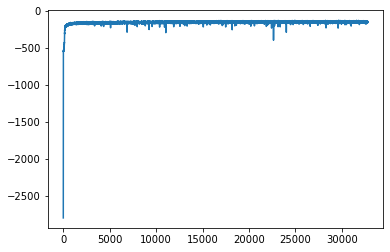

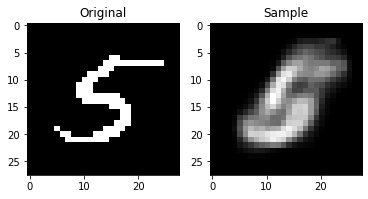

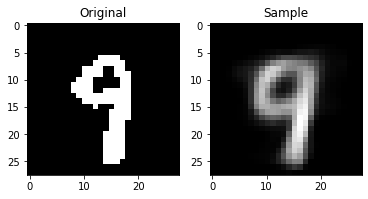

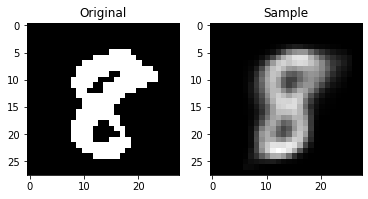

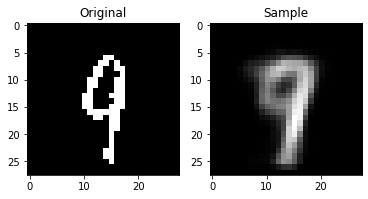

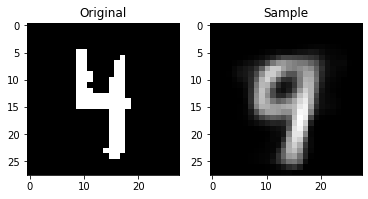

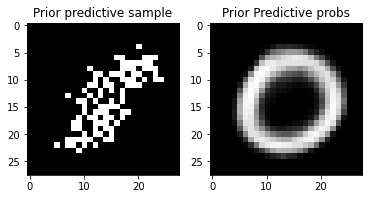

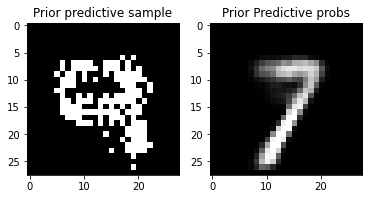

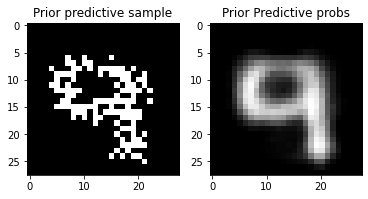

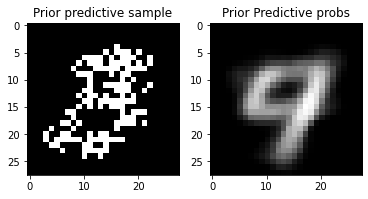

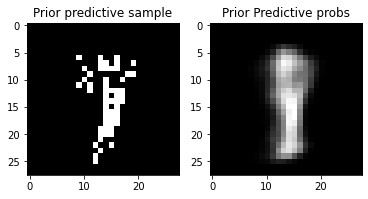

In [8]:
def main():
    X,Y=np.concatenate([mnist.load_data()[0][0],mnist.load_data()[1][0]]),np.concatenate([mnist.load_data()[0][1],mnist.load_data()[1][1]])
    X=X.astype("float32")/255.0
    X=X.reshape(-1,28*28)
    #X=X[:10000]
    #Y=Y[:10000]
    X,Y=shuffle(X,Y)
    #hacemos X variable binaria
    X=(X>.5).astype(np.float32)
    vae=Vae(784,[100,2])
    vae.fit(X)
    
    #plot reconstrucción
    done=False
    #while not done:
    for _ in range(5):
        i=np.random.choice(len(X))
        x=X[i]
        im=vae.posterior_predictive_sample([x]).reshape(28,28)
        plt.subplot(1,2,1)
        plt.imshow(x.reshape(28,28),cmap="gray")
        plt.title("Original")
        plt.subplot(1,2,2)
        plt.imshow(im,cmap="gray")
        plt.title("Sample")
        plt.show()

        #ans=input("otro?")
        #if ans and ans[0] in ('n' or 'N'):
        #    done=True
       #plot output in latent spaces Z's 
    done=False
    #while not done:
    
    for _ in range(5):
        im,probs=vae.prior_predictive_sample_with_probs()
        im=im.reshape(28,28)
        probs=probs.reshape(28,28)
        plt.subplot(1,2,1)
        plt.imshow(im,cmap="gray")
        plt.title("Prior predictive sample")
        plt.subplot(1,2,2)
        plt.imshow(probs,cmap="gray")
        plt.title("Prior Predictive probs")
        plt.show()

       # ans=input("otro?")
       # if ans and ans[0] in ('n' or 'N'):
         #   done=True
    
if __name__=='__main__':
    main()